# Predicting the gender of lead actors in Hollywood films

This notebook guides you step by step through the process of analyzing film data 
and building classification models to predict whether the lead actor in a movie is male or female. 

We'll explore the data, engineer some features, tune different machine learning models, 
and finally choose the best one to make our predictions.


## Step 1: Importing libraries and setting up the environment

This section imports the necessary Python libraries for data analysis, visualization, 
and machine learning. A random seed is also set to ensure the results are reproducible.


In [6]:
from IPython.core.pylabtools import figsize
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import sklearn.preprocessing as skl_pre
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


pd.options.mode.chained_assignment = None
np.random.seed(1)


## Step 2: Loading the data

The training and test datasets are loaded using `pandas`. This also prints out the shape 
of the training data to give an initial sense of its size.


In [7]:
train = pd.read_csv('../data/train.csv')
print(f"Train data shape: {train.shape}")

test = pd.read_csv('../data/test.csv')


Train data shape: (1039, 14)


## Step 3: Feature engineering

New features are created to better capture the relationships in the data:

- **Co-lead words** estimates the proportion of words spoken by the co-lead.
- **Percentage of words spoken by female and male actors** normalizes dialogue counts.

The columns `Total words` and `Difference in words lead and co-lead` are then dropped, 
since their information is incorporated into the new features. The same transformations 
are applied to both the training and test datasets.


In [8]:
# Create new features for training data
train["Co-lead words"] = (
    (train["Number of words lead"] - train["Difference in words lead and co-lead"])
    / train["Total words"]
)
train["percentage female"] = train["Number words female"] / train["Total words"]
train["percentage male"] = train["Number words male"] / train["Total words"]

# Drop columns no longer needed
train = train.drop(["Difference in words lead and co-lead", "Total words"], axis=1)

# Apply the same transformations to test data
test["Co-lead words"] = (
    (test["Number of words lead"] - test["Difference in words lead and co-lead"])
    / test["Total words"]
)
test["percentage female"] = test["Number words female"] / test["Total words"]
test["percentage male"] = test["Number words male"] / test["Total words"]

test = test.drop(["Difference in words lead and co-lead", "Total words"], axis=1)

# Split features and target
X = train.drop("Lead", axis=1)
y = train["Lead"]


## Step 4: Finding the optimal *k* for k-Nearest Neighbors

This step uses repeated cross-validation to find the best number of neighbors (*k*) 
for the k-NN classifier. Accuracy is calculated over multiple runs to ensure 
the selection is stable. The results are then plotted to visualize how accuracy 
changes with different values of *k*.


Optimal k: 14 with average accuracy: 0.8878


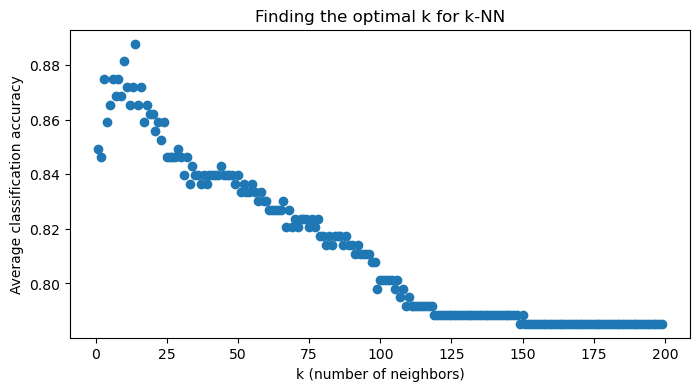

In [9]:
n_runs = 10
K = np.arange(1, 200)
classification = np.zeros((n_runs, len(K)))

# Repeated cross-validation to estimate best k
for i in range(n_runs):
    x_train, x_val, y_train, y_val = skl_ms.train_test_split(
        X, y, test_size=0.3, random_state=1
    )
    scaler = skl_pre.StandardScaler().fit(x_train)
    
    for j, k in enumerate(K):
        model = skl_nb.KNeighborsClassifier(n_neighbors=k)
        model.fit(scaler.transform(x_train), y_train)
        prediction = model.predict(scaler.transform(x_val))
        classification[i, j] = np.mean(prediction == y_val)

# Compute average accuracy across runs
average_classification = np.mean(classification, axis=0)
optimal_k_index = np.argmax(average_classification)
optimal_k = K[optimal_k_index]
optimal_accuracy = average_classification[optimal_k_index]

print(f"Optimal k: {optimal_k} with average accuracy: {optimal_accuracy:.4f}")

# Plot accuracy vs k
plt.figure(figsize=(8, 4))
plt.scatter(K, average_classification)
plt.xlabel("k (number of neighbors)")
plt.ylabel("Average classification accuracy")
plt.title("Finding the optimal k for k-NN")
plt.show()


## Step 5: Tuning Random Forest hyperparameters

Grid search with cross-validation is used to tune `n_estimators` (number of trees) and 
`max_leaf_nodes` (maximum leaf nodes per tree). The best combination of parameters is printed 
along with its cross-validated accuracy.


In [10]:
param_grid = {
    'n_estimators': list(range(10, 100, 10)),
    'max_leaf_nodes': list(range(10, 100, 10)),
    'random_state': [1]
}

grid_search = skl_ms.GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True
)

grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")


Best parameters found: {'max_leaf_nodes': 90, 'n_estimators': 60, 'random_state': 1}
Best cross-validated accuracy: 0.8980


# Comparing different models with k-fold cross-validation

To understand how our selected models perform relative to each other, we run a k-fold cross-validation 
process (with 5 folds) and calculate the validation error for each model. This gives us a clearer picture 
of which models are more stable and accurate on unseen data.

We include:

- Quadratic Discriminant Analysis (QDA)
- k-Nearest Neighbors with the optimal *k* we found
- Random Forest with tuned hyperparameters

Finally, we plot a boxplot of the validation errors for each model to visualize their performance spread.


In [ ]:
# Define the models to compare
models = []
models.append(skl_da.QuadraticDiscriminantAnalysis())
models.append(skl_nb.KNeighborsClassifier(n_neighbors=optimal_k))
models.append(RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_leaf_nodes=grid_search.best_params_['max_leaf_nodes'],
    random_state=1
))

# k-fold cross-validation
n_fold = 5
misclassification = np.zeros((n_fold, len(models)))
cv = skl_ms.KFold(n_splits=n_fold, random_state=2, shuffle=True)

for i, (train_index, val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for j, model in enumerate(models):
        scaler = skl_pre.StandardScaler().fit(X_train)
        model.fit(scaler.transform(X_train), y_train)
        prediction = model.predict(scaler.transform(X_val))
        misclassification[i, j] = np.mean(prediction != y_val)

# Boxplot to compare validation errors
plt.boxplot(misclassification)
plt.xticks(np.arange(len(models)) + 1, [type(model).__name__ for model in models])
plt.ylabel("Validation Error")
plt.title("Model comparison with k-fold cross-validation")
plt.show()


# Training the final model and generating predictions

Based on our cross-validation results, we choose the Quadratic Discriminant Analysis (QDA) model 
as our final model for production. We train it on the entire training dataset to leverage all available data.

Finally, we predict on the test set and save the results in a CSV file named `predictions.csv`,
formatted as required for submission.


In [ ]:
# Final QDA model trained on full training data
final_model = skl_da.QuadraticDiscriminantAnalysis()
final_model.fit(X, y)

# Make predictions on test set
final_predictions = final_model.predict(test)

# Convert to 0/1: 0 for Male, 1 for Female
final_predictions = np.where(final_predictions == "Male", 0, 1).reshape(1, -1)

# Save to predictions.csv without index and header
pd.DataFrame(final_predictions).to_csv("../results/predictions.csv", index=False, header=False)
